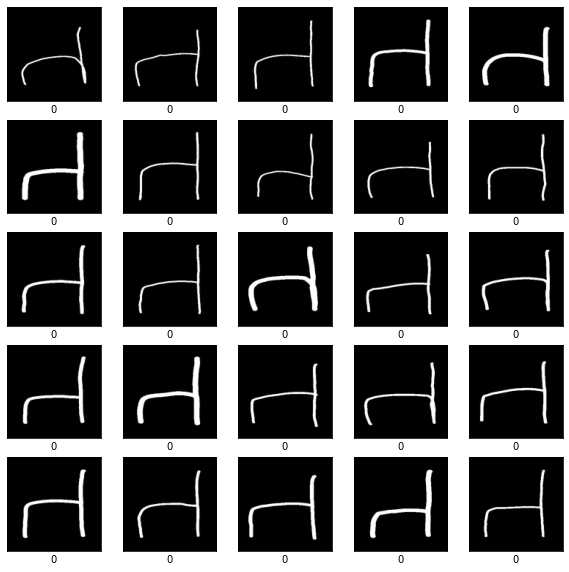

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 4, 4, 2048)        20861480  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                      

In [5]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetV2S,Xception,ResNet101,InceptionV3
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from PIL import Image, ImageOps

# Set learning rate, number of epochs, momentum, and batch size
learning_rate = 0.0001
num_epochs = 30
momentum = 0.9
batch_size = 32
dropout = 0.5

# Set the minimum learning rate and patience for ReduceLROnPlateau
min_learning_rate = 0.00001
patience = 3

train_data_dir = r"C:/Users/91758/Downloads/dataset/train_set"
test_data_dir = r"C:/Users/91758/Downloads/dataset/test_set"
valid_data_dir = r"C:/Users/91758/Downloads/dataset/validation_set"

image_width, image_height = 128, 128

# Get the list of class directories in the training and testing data directories
train_class_dirs = [os.path.join(train_data_dir, class_folder) for class_folder in os.listdir(train_data_dir)]
test_class_dirs = [os.path.join(test_data_dir, class_folder) for class_folder in os.listdir(test_data_dir)]
valid_class_dirs = [os.path.join(valid_data_dir, class_folder) for class_folder in os.listdir(valid_data_dir)]
# Count the total number of training and testing images
num_train_images = sum([len(files) for _, _, files in os.walk(train_data_dir)])
num_test_images = sum([len(files) for _, _, files in os.walk(test_data_dir)])
num_valid_images = sum([len(files) for _, _, files in os.walk(valid_data_dir)])


class_name_to_label = {
    "Ta": 0,
    "Taa": 1,
    "Tah": 2,
    "Tam": 3,
    "Te": 4,
    "Tee": 5,
    "Ti": 6,
    "Tii": 7,
    "To": 8,
    "Too": 9,
    "Tri": 10,
    "Tu": 11,
    "Tuu": 12,
    # Add more class names and labels here
}


# Create empty NumPy arrays to store the training and testing image data
train_images = np.zeros((num_train_images, image_height, image_width), dtype=np.uint8)
train_labels = np.zeros(num_train_images, dtype=np.int64)
test_images = np.zeros((num_test_images, image_height, image_width), dtype=np.uint8)
test_labels = np.zeros(num_test_images, dtype=np.int64)
valid_images = np.zeros((num_valid_images, image_height, image_width), dtype=np.uint8)
valid_labels = np.zeros(num_valid_images, dtype=np.int64)

# Read and convert each training image to a 2D array
# index = 0
# for class_dir in train_class_dirs:
#     class_label = int(os.path.basename(class_dir).split("_")[0])
#     for image_file in os.listdir(class_dir):
#         image_path = os.path.join(class_dir, image_file)
#         train_image = Image.open(image_path).convert("L")
#         train_image = ImageOps.fit(train_image, (image_width, image_height), method=Image.LANCZOS)
#         train_image_array = np.array(train_image)
#         train_images[index] = train_image_array
#         train_labels[index] = class_label
#         index += 1
index = 0
for class_dir in train_class_dirs:
    class_name = os.path.basename(class_dir)
    class_label = class_name_to_label.get(class_name, -1)  # Default to -1 if class name not found
    if class_label != -1:
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            train_image = Image.open(image_path).convert("L")
            train_image = ImageOps.fit(train_image, (image_width, image_height), method=Image.LANCZOS)
            train_image_array = np.array(train_image)
            train_images[index] = train_image_array
            train_labels[index] = class_label
            index += 1


# Read and convert each testing image to a 2D array
# index = 0
# for class_dir in test_class_dirs:
#     class_label = int(os.path.basename(class_dir).split("_")[0])
#     for image_file in os.listdir(class_dir):
#         image_path = os.path.join(class_dir, image_file)
#         test_image = Image.open(image_path).convert("L")
#         test_image = ImageOps.fit(test_image, (image_width, image_height), method=Image.LANCZOS)
#         test_image_array = np.array(test_image)
#         test_images[index] = test_image_array
#         test_labels[index] = class_label
#         index += 1

index = 0
for class_dir in test_class_dirs:
    class_name = os.path.basename(class_dir)
    class_label = class_name_to_label.get(class_name, -1)  # Default to -1 if class name not found
    if class_label != -1:
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            test_image = Image.open(image_path).convert("L")
            test_image = ImageOps.fit(test_image, (image_width, image_height), method=Image.LANCZOS)
            test_image_array = np.array(test_image)
            test_images[index] = test_image_array
            test_labels[index] = class_label
            index += 1

# Read and convert each testing image to a 2D array
index = 0
for class_dir in valid_class_dirs:
    class_name = os.path.basename(class_dir)
    class_label = class_name_to_label.get(class_name, -1)  # Default to -1 if class name not found
    if class_label != -1:
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            valid_image = Image.open(image_path).convert("L")
            valid_image = ImageOps.fit(valid_image, (image_width, image_height), method=Image.LANCZOS)
            valid_image_array = np.array(valid_image)
            valid_images[index] = valid_image_array
            valid_labels[index] = class_label
            index += 1


# Show the first 25 images in the training dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.gray)
    plt.xlabel(train_labels[i])
plt.show()


# Convert labels to categorical format
num_classes = len(np.unique(train_labels))
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)
valid_labels = to_categorical(valid_labels, num_classes)

# Load the pre-trained EfficientNetV2S model
# base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=(image_height, image_width, 3))
base_model = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model architecture
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(256, activation="relu"))
model.add(Dropout(dropout))
model.add(Dense(num_classes, activation="softmax"))
model.summary()
from keras.utils import plot_model
plot_model(model , show_shapes=True)

In [6]:

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
valid_images = valid_images / 255.0

train_images = np.repeat(train_images[..., np.newaxis], 3, axis=-1)
test_images = np.repeat(test_images[..., np.newaxis], 3, axis=-1)
valid_images = np.repeat(valid_images[..., np.newaxis], 3, axis=-1)

train_images.shape
test_images.shape
valid_images.shape


(234, 128, 128, 3)

In [7]:

# Define data augmentation on images
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.25,
    zoom_range=0.1,
)

train_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)

test_generator = datagen.flow(test_images, test_labels, batch_size=batch_size)

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss="categorical_crossentropy",
              metrics=["accuracy"])


# Define callbacks for ReduceLROnPlateau and EarlyStopping
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=patience, min_lr=min_learning_rate)
early_stop = EarlyStopping(monitor="val_loss", patience=patience)

# Start the training time
start_time = time.time()

# Train the model with augmented data
history = model.fit(train_generator, steps_per_epoch=len(train_images) // batch_size, epochs=num_epochs,
                    validation_data=test_generator, validation_steps=len(test_images) // batch_size,
                    callbacks=[reduce_lr, early_stop])


# Calculate training time
training_time = time.time() - start_time


# Evaluate the model on training and testing data
train_loss, train_accuracy = model.evaluate(train_images, train_labels, verbose=0)
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=0)

# Make predictions on the testing data
test_predictions = model.predict(test_images)
test_predictions_labels = np.argmax(test_predictions, axis=1)

# Calculate precision, recall, AUC score, and confusion matrix
classification_report_result = classification_report(np.argmax(test_labels, axis=1), test_predictions_labels, output_dict=True)
precision = classification_report_result["weighted avg"]["precision"]
recall = classification_report_result["weighted avg"]["recall"]
auc_score = roc_auc_score(test_labels, test_predictions, average="weighted")
confusion_mat = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions_labels)

# Get the total number of parameters and trainable parameters
total_params = model.count_params()
trainable_params = np.sum([np.prod(var.shape) for var in model.trainable_variables])

# Calculate CPU inference time for the testing data
start_time = time.time()
model.predict(test_images)
inference_time = time.time() - start_time

# Print the evaluation metrics and model information
print("Training Accuracy:", train_accuracy)
print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC Score:", auc_score)
print("Total Parameters:", total_params)
print("Trainable Parameters:", trainable_params)
print("CPU Inference Time:", inference_time)
print("Training Time:", training_time)

font=18
lw=2.5
# Plot accuracy vs epoch for training and testing datasets
plt.figure(figsize=(10, 10))
plt.plot(history.history["accuracy"], linewidth=lw)
plt.plot(history.history["val_accuracy"], linewidth=lw)
plt.title("Model Accuracy", fontsize=font)
plt.xlabel("Epoch", fontsize=font)
plt.ylabel("Accuracy", fontsize=font)
plt.xticks(fontsize=font - 2)  # Reduce font size of tick labels
plt.yticks(fontsize=font - 2)  # Reduce font size of tick labels
plt.legend(["Train", "Test"], loc="upper left", fontsize=font)
plt.show()

# Plot loss vs epoch for training and testing datasets
plt.figure(figsize=(10, 10))
plt.plot(history.history["loss"], linewidth=lw)
plt.plot(history.history["val_loss"], linewidth=lw)
plt.title("Model Loss", fontsize=font)
plt.xlabel("Epoch", fontsize=font)
plt.ylabel("Loss", fontsize=font)
plt.xticks(fontsize=font - 2)  # Reduce font size of tick labels
plt.yticks(fontsize=font - 2)  # Reduce font size of tick labels
plt.legend(["Train", "Test"], loc="upper left", fontsize=font)
plt.show()


# Add numerical values inside the cells

# Plot confusion matrix
plt.figure(figsize=(10, 10))
for i in range(len(confusion_mat)):
    for j in range(len(confusion_mat)):
        plt.text(j, i, confusion_mat[i, j], ha='center', va='center', color='Black', fontsize=font)
plt.imshow(confusion_mat, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix",fontsize=font)
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_name_to_label.keys(),rotation=45,fontsize=font)
plt.yticks(tick_marks, class_name_to_label.keys(),fontsize=font)
plt.xlabel("Predicted Label",fontsize=font)
plt.ylabel("True Label",fontsize=font)
plt.show()


Epoch 1/30
34/34 [==============================] - 23s 598ms/step - loss: 2.6106 - accuracy: 0.1057 - val_loss: 2.3300 - val_accuracy: 0.2902 - lr: 1.0000e-04
Epoch 2/30
34/34 [==============================] - 20s 590ms/step - loss: 2.3041 - accuracy: 0.2311 - val_loss: 2.0371 - val_accuracy: 0.4643 - lr: 1.0000e-04
Epoch 3/30
34/34 [==============================] - 20s 576ms/step - loss: 2.0877 - accuracy: 0.3368 - val_loss: 1.8117 - val_accuracy: 0.5268 - lr: 1.0000e-04
Epoch 4/30
34/34 [==============================] - 19s 555ms/step - loss: 1.8866 - accuracy: 0.4104 - val_loss: 1.6433 - val_accuracy: 0.5714 - lr: 1.0000e-04
Epoch 5/30
34/34 [==============================] - 21s 619ms/step - loss: 1.7760 - accuracy: 0.4340 - val_loss: 1.3805 - val_accuracy: 0.7321 - lr: 1.0000e-04
Epoch 6/30
34/34 [==============================] - 23s 676ms/step - loss: 1.5606 - accuracy: 0.5028 - val_loss: 1.3158 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 7/30
34/34 [======================

8/8 [==============================] - 8s 939ms/step


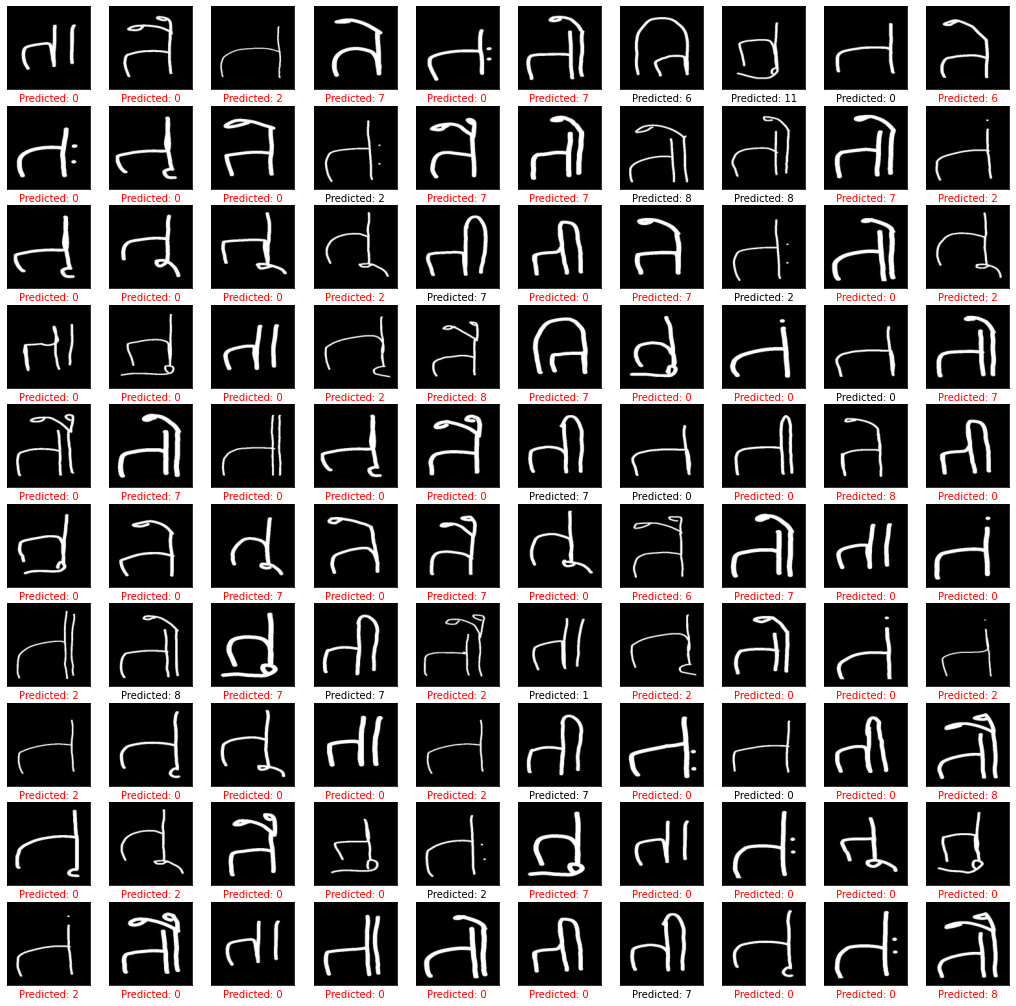

In [ ]:
import random
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
    if (val1==val2):
        return 'black'
    else:
        return 'red'

# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)

# As the model output 10 float representing the probability of the input image
# being a digit from 0 to 9, we need to find the largest probability value
# to find out which digit the model predicts to be most likely in the image.
prediction_digits = np.argmax(predictions, axis=1)

# Then plot 100 random test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits) - 1)  # Generate a random index within valid range
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index], np.argmax(test_labels[image_index])))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()